In [1]:
#from tqdm import tqdm_notebook, tqdm
from tqdm.notebook import tqdm
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import Button, Layout
from dotenv import load_dotenv
from datetime import datetime
from pathlib import Path
from time import sleep
import pandas as pd
import os

In [2]:
# alpaca_api = 0

def app_init():
    global alpaca_api
    load_dotenv()

    sp500_tickers_df = pd.read_csv(Path("dataset/symbols.csv"), header=None)
    #display(sp500_tickers_df.head(3))
    #display(sp500_tickers_df.tail(3))
    sp500_tickers = sp500_tickers_df.loc[:,0]

    # Setting the variables for the Alpaca API and secret keys
    alpaca_api_key = os.getenv('ALPACA_API_KEY')
    alpaca_api_secret_key = os.getenv('ALPACA_SECRET_KEY')

    #display(type(alpaca_api_key))
    #display(type(alpaca_api_secret_key))

    # Create the Alpaca tradeapi.REST object
    alpaca_api = tradeapi.REST(alpaca_api_key, alpaca_api_secret_key, api_version = "v2")

    return(sp500_tickers, alpaca_api)

#     # Set start and end dates of 3 years back from your current date
#     timeframe="1D"
#     today=pd.Timestamp.now()
#     start_date = pd.Timestamp(today - pd.Timedelta(days=1000), tz="America/New_York").isoformat()
#     end_date = pd.Timestamp(today).isoformat()
#     max_rows=1000

In [3]:
timeframe="1D"
today=pd.Timestamp.now()

year_start_date = pd.Timestamp(today - pd.Timedelta(days=365), tz="America/New_York").isoformat()
end_date = pd.Timestamp(today).isoformat()

max_rows=365

def get_alpaca_price(tickers):
    ticker_df=alpaca_api.get_barset(
    tickers,
    timeframe,
    start=year_start_date,
    end=end_date,
    limit=max_rows
    ).df

    return (ticker_df)

In [4]:
# Alternative?  https://stackoverflow.com/questions/48775841/pandas-ema-not-matching-the-stocks-ema
# ta.ema shown at the end of that page.  Is sorting index necessary?
#import pandas_ta as ta
#
#data["EMA20"] = ta.ema(df2["Close"], length=20)

def add_EMA(price, day):
    return price.ewm(span=day).mean()

# function to check for EMA crossing
def check_EMA_crossing(df):
    # condition 1: EMA18 is higher than EMA50 at the last trading day
    cond_1 = df.iloc[-1]['EMA18'] > df.iloc[-1]['EMA50']
    # condition 2: EMA18 is lower than EMA50 the previous day
    cond_2 = df.iloc[-2]['EMA18'] < df.iloc[-2]['EMA50']
    # condition 3: to filter out stocks with less than 50 candles
    cond_3 = len(df.index) > 50 
    # will return True if all 3 conditions are met
    return (cond_1 and cond_2 and cond_3)

In [5]:
# If date range is dropdown-selectable, then need to pass start and end dates
# to get_ticker_prices, instead of relying on values from app_init()

def screen_tickers(ticker_list):
    """
    Screen S&P tickers by Exponential Moving Average
    
    Parameters: ticker_list 
    
    Returns: the screened list of tickers
    """
    
    # Preliminary ticker list after screening based on EMA
    # Step 1: get all sp500 prices
    sp500_df = get_ticker_prices(ticker_list[0:1], 252)
    done = False
    ticker_count = len(ticker_list) -1
    start=1
    end=101
    # each dataframe has 100 tickers, concat them
    printmd("## Getting Alpacas ticker data:")

    while not done:
        partial_df = get_ticker_prices(ticker_list[start:end], 252)
        sp500_df = pd.concat([sp500_df, partial_df], axis=1)
        start +=100
        end += 100
        if end >= 602:
            done = True

    #display(sp500_df)
    
    screened_list = [] 

    stock_list = ticker_list
    #for each_stock in tqdm_notebook(stock_list):
    printmd(f"## Screening {ticker_count} S&P 500 tickers:")
    for each_stock in tqdm(stock_list, leave=False):
        ##
        ticker_df = sp500_df[each_stock]
        close_df = pd.DataFrame(columns = ['close'])
        close_df['close'] = ticker_df['close']
        ##
        
        # Step 2: add technical indicators (in this case EMA)
        close_df['EMA18']=add_EMA(close_df['close'],18)
        close_df['EMA50']=add_EMA(close_df['close'],50)
        close_df['EMA100']=add_EMA(close_df['close'],100)
        # if all 3 conditions are met, add stock into screened list
        if check_EMA_crossing(close_df):
            screened_list.append(each_stock)
        #sleep(0.2)

    return (screened_list)


In [6]:
# # Work out the kinks without haveing to run the above every time.
# # ['BA', 'DISCA', 'D', 'EVRG', 'GL', 'HRL', 'MA']
# saved_screened_list = ['AEE', 'DISCK', 'NEM', 'NLSN', 'WYNN']
# print(saved_screened_list[:3])
# #short_list = ['AEE', 'DISCK', 'NEM']
# display(price_chart_df.head())
# display(price_chart_df.tail())

In [7]:
#
#  Analyze screened_list for Sharpes, beta, etc.  
#  Reduce list to three best tickers.
#

In [8]:
# If date range is dropdown-selectable, then will use given end date,
# calculate back three years to get start_date
# instead of relying on values from app_init()

def get_ticker_prices(tickers, num_days=1000):
    """
    Use Alpacas to get ticker price data.

    Parameters:
        tickers: list of stock tickers
        days: days of historical data to get (limit 1000)

    Return value:  DataFrame of ticker price data
    """ 
    
    # Set start and end datetimes between now and num_days ago

    timeframe="1D"
    today=pd.Timestamp.now()
    start_date = pd.Timestamp(today - pd.Timedelta(days=num_days), tz="America/New_York").isoformat()
    end_date = pd.Timestamp(today).isoformat()
    # Set number of rows to three years of days
    limit_rows = 1000

    # Get 3 years’ worth of historical price data for Microsoft and Coca-Cola
    prices_df = alpaca_api.get_barset(
        tickers,
        timeframe,
        start=start_date,
        end=end_date,
        limit=limit_rows
    ).df

    return(prices_df)
   

In [9]:
# Eventually these belong in the app_init() function

MC_median_df_dict = {}
MC_sim_df_dict = {}


# weights_dict = {
#     0:[.33,.33,.33],
#     1:[.10,.30,.60],
#     2:[.60,.30,.10],
#     3:[.20,.40,.40],
#     4:[.40,.40,.20],
#     5:[.20,.60,.20],  
#     6:[.20,.50,.30],
#     7:[.30,.20,.50]
# }
weights_dict3 = {0:[.33,.33,.33],1:[.10,.30,.60],2:[.60,.30,.10],3:[.20,.40,.40],4:[.40,.40,.20],5:[.20,.60,.20],6:[.20,.50,.30],7:[.30,.20,.50]}
weights_dict2 = {0:[.50,.50],1:[.40,.60],2:[.60,.40],3:[.30,.70],4:[.70,.30],5:[.20,.80],6:[.80,.20]}
weights_dict1 = {0:[1.0]}
weights_list = [weights_dict1, weights_dict2, weights_dict3]

In [25]:

def run_MC(tickers_df, sim_duration, sim_count):
    # print ticker names
    #   Change MCF code to print Running Monte Carlo simulatioin for {weights[i]}
    for i in range(len(weights_dict)):
        #output.clear_output()
        
        # Add Monte Carlo code from M_5.3.3_MCForecast
        # Configure a Monte Carlo simulation to forecast five years cumulative returns
        #display(f"using num_trading_days: {sim_count} simulations: {sim_duration}")
        MC_sim_config = MCSimulation(
            portfolio_data = tickers_df,
            weights = weights_dict[i],
            num_simulation = sim_count,
            num_trading_days = sim_duration
        )

        # Printing the simulation input data
        #MC_sim_config.portfolio_data.head()

        MC_sim = MC_sim_config.calc_cumulative_return()
        #display(MC_sim.head(3))

        MC_sim_median = MC_sim.median(axis=1)

        MC_median_df_dict[i] = MC_sim_median
        
        return(MC_sim_config)
    
        # It might be interesting to do plt.ioff(),
        # and figure out an additive side-by-side plot, doing plot.show after the loop.
        # Or just don't print these at all
#         ax=MC_sim.plot(legend=None)
#         MC_sim_median.plot(ax=ax,linewidth=10)
#         plt.ylim([0.7,1.8])
#         plt.show


In [39]:
def main():
    global weights_dict
    global screened_ticker_list
    
    plot_output = widgets.Output()
    
    # Get all sp500 tickers
    ticker_list, alpaca_api = app_init()

    # Run screening to get preferred short list
    screened_ticker_list = screen_tickers(ticker_list)

    # For Demo, may have to use this
    #screened_ticker_list = ['AEE', 'DISCK', 'NEM']
    if len(screened_ticker_list) < 3:
        weights_dict = weights_list[len(screened_ticker_list) -1]
    else:
        weights_dict = weights_dict3

    #display(print("weights_dict: ", weights_dict))

    #display(screened_ticker_list)
    # Analyze to reduce short list to optimal list
    # optimal_ticker_list = analyze_tickers(screened_ticker_list)

    # until analyze_tickers() exists, take just first three of list
    test_list = screened_ticker_list[:3]
    #screened_df = get_ticker_prices(optimal_ticker_list, 252)
    optimal_df = get_ticker_prices(test_list, 1000)

    printmd(f"## Running {len(weights_dict)} Monte Carlo simulations of varying portfolio weights:")
    MC_sim_class = run_MC(optimal_df, MC_sim_duration, MC_sim_count)

    fig, axes = plt.subplots(1,2)
    with plot_output:
        for key in MC_median_df_dict:
            MC_median_df_dict[key].plot(ax=axes[0], legend=True, figsize=(15,5), label=str(weights_dict[key]))
        
        MC_sim_dist_plot = MC_sim_class.plot_distribution()

        plt.show()

    display(plot_output)    

#fig, axes = plt.subplots(1,2)
#df_base.plot(ax=axes[0], figsize=(25,5))
#df_spikes.plot(ax=axes[1])

In [40]:
from IPython.display import Markdown, display
from IPython.display import clear_output


MC_sim_duration = 252
MC_sim_count = 200

def printmd(string):
    display(Markdown(string))
    
def menu_sim_duration_eventhandler(change):
    set_sim_duration(change.new)
    
def menu_sim_count_eventhandler(change):
    set_sim_count(change.new)

output = widgets.Output()
plot_output = widgets.Output()
output.clear_output()

# convert sim_time to days
menu_sim_duration = widgets.Dropdown(options =  ['1 year', '2 years', '3 years'])

# number of simulations to run
menu_sim_count = widgets.Dropdown(options = ['200', '300', '400', '500'])
#bounded_num = widgets.BoundedFloatText(min=0, max=100000, value=5, step=1)

btn = widgets.Button(description='Run S&P 500 Portfolio Advisor', layout=Layout(width='auto'))
btn.style.button_color = 'lightgreen'

menu_sim_duration.observe(menu_sim_duration_eventhandler, names='value')
menu_sim_count.observe(menu_sim_count_eventhandler, names='value')

@output.capture()
def btn_eventhandler(obj):
    clear_output()
    #print('Hello from the {} button!'.format(obj.description))
    main()

btn.on_click(btn_eventhandler)

@output.capture()
def set_sim_duration(value):
    global MC_sim_duration
    if value == '1 years':
        MC_sim_duration = 252
    elif value == '2 years':
        MC_sim_duration = 504
    elif value == '3 years':
        MC_sim_duration = 756

@output.capture()
def set_sim_count(value):
    global MC_sim_count
    MC_sim_count=int(value)

printmd("## Choose duration for Monte Carlo simulations:")
display(menu_sim_duration)
printmd("## Choose interations for Monte Carlo simulations:")

display(menu_sim_count)
display(btn)

display(output)
display(plot_output)

## Choose duration for Monte Carlo simulations:

Dropdown(options=('1 year', '2 years', '3 years'), value='1 year')

## Choose interations for Monte Carlo simulations:

Dropdown(options=('200', '300', '400', '500'), value='200')

Button(description='Run S&P 500 Portfolio Advisor', layout=Layout(width='auto'), style=ButtonStyle(button_colo…

Output()

Output()

In [41]:
screened_ticker_list = ['AEE', 'DISCK', 'NEM']

In [28]:
type(MC_sim_duration)

int

<AxesSubplot:>

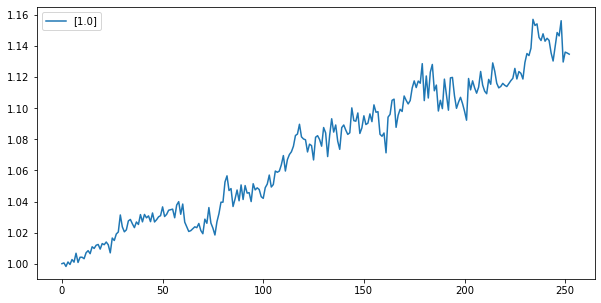

In [34]:
MC_median_df_dict[0].plot(legend=True, figsize=( 10,5),label=str(weights_dict[0]))
